## Workflow

1. Check stock splits and transform the data

2. Check the history volatility and truncate the data

### Import the necessary program libraries

In [1]:
import pandas as pd
import plotly.graph_objects as go
from classes import BaseLoader
import plotly.express as px
from funcs import to_float, get_color
from matplotlib.colors import Normalize
from matplotlib import cm
import matplotlib.colors as mcolors
from sqlalchemy import create_engine
from settings import mariadb_string, mariadb_config
from time import sleep

### Select the data

In [2]:
select_query = """select 
	*
from
	stock_price s
where
	s.symbol = '{}'
group BY
	s.`date`
order by
	s.`date` asc;"""

loader = BaseLoader(mariadb_config)
symbol = loader.choose_id()
df_stock = pd.read_sql(select_query.format(symbol), create_engine(mariadb_string))
df_stock["date"] = pd.to_datetime(df_stock["date"])
df_stock.info()

Please choose the symbol from the index which data should be analysed.
symbol ADS.DEX: Adidas
symbol AMZN: Amazon
symbol BKNG: Booking Holdings
symbol DASH: DoorDash
symbol FNTN.DE: Freenet
symbol HD: Home Depot
symbol LOW: Lowe’s
symbol MCD: McDonald's
symbol NKE: Nike
symbol NRDBY: Nordea Bank Abp ADR
symbol PAH3.DE: Porsche SE
symbol SBUX: Starbucks
symbol SY1.DE: Symrise
symbol TJX: TJX Companies
symbol TSLA: Tesla
You can typ 'q' to quit.


symbol:  NRDBY


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1717 entries, 0 to 1716
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   symbol  1717 non-null   object        
 1   date    1717 non-null   datetime64[ns]
 2   open    1717 non-null   float64       
 3   high    1717 non-null   float64       
 4   low     1717 non-null   float64       
 5   close   1717 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 80.6+ KB


### Check the data

In [3]:
# Check the dates
df_stock.loc[df_stock["date"] > "2015-12-20"].head()

,symbol,date,open,high,low,close
2790,PAH3.DE,2015-12-21,49.01,50.58,48.860,49.125
2791,PAH3.DE,2015-12-22,49.98,50.55,49.495,50.120
2792,PAH3.DE,2015-12-23,50.85,51.37,50.570,51.270
2793,PAH3.DE,2015-12-28,51.39,51.48,50.350,50.400
2794,PAH3.DE,2015-12-29,50.92,50.99,50.120,50.790


In [3]:
df_stock.head()

,symbol,date,open,high,low,close
0,NRDBY,2018-10-02,10.90,10.90,10.30,10.70
1,NRDBY,2018-10-03,10.30,11.05,9.65,10.00
2,NRDBY,2018-10-04,10.10,10.80,9.80,9.93
3,NRDBY,2018-10-05,9.95,13.30,8.78,9.46
4,NRDBY,2018-10-08,9.85,11.00,9.05,9.40


In [4]:
df_stock.tail()

,symbol,date,open,high,low,close
1712,NRDBY,2025-07-28,14.81,14.81,14.61,14.610
1713,NRDBY,2025-07-29,14.80,14.91,14.65,14.785
1714,NRDBY,2025-07-30,14.84,14.89,14.70,14.750
1715,NRDBY,2025-07-31,14.61,14.74,14.61,14.700
1716,NRDBY,2025-08-01,14.64,14.73,14.53,14.680


### Check the chart

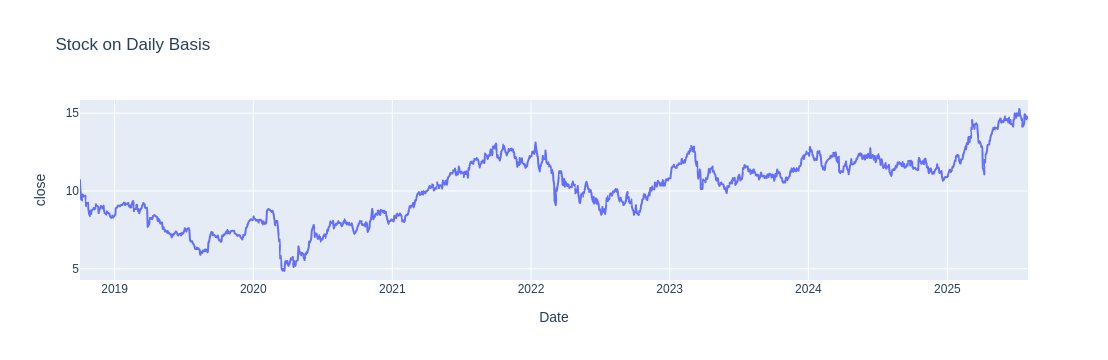

In [5]:
fig = px.line(df_stock, x="date", y="close", title="Stock on Daily Basis", 
              labels={"date": "Date"})

fig.show()

### Adjust stock splits

In [12]:
# Some initial values
try:
    divisor = input("Divisor: ")
    divisor = int(divisor)
except ValueError:
    divisor = float(divisor)
    
split_date = input("Split Date (yyyy-mm-dd): ")
update_query = """UPDATE stock_price SET `open`=`open`/{divisor}, high=`high`/{divisor}, low=`low`/{divisor}, `close`=`close`/{divisor}
where `date` < '{split_date}' and symbol='{symbol}';""".format(divisor=divisor, split_date=split_date, symbol=symbol)
affected_rows = 0

# Make the update
truncate_bool = input("Update the database? (y/n): ")
if truncate_bool in ("y", "Y"):
    affected_rows = loader.query(update_query)
    sleep(1)
    df_stock = pd.read_sql(select_query.format(symbol), create_engine(mariadb_string))
    df_stock["date"] = pd.to_datetime(df_stock["date"])
    
print("\nAffected Rows in database:", affected_rows)
print("Sql Query:", update_query)
print(df_stock.info())

Divisor:  10
Split Date (yyyy-mm-dd):  2001-04-23
Update the database? (y/n):  y



Affected Rows in database: 0
Sql Query: UPDATE stock_price SET `open`=`open`/10, high=`high`/10, low=`low`/10, `close`=`close`/10
where `date` < '2001-04-23' and symbol='PAH3.DE';
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5219 entries, 0 to 5218
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   symbol  5219 non-null   object        
 1   date    5219 non-null   datetime64[ns]
 2   open    5219 non-null   float64       
 3   high    5219 non-null   float64       
 4   low     5219 non-null   float64       
 5   close   5219 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 244.8+ KB
None


### The Volatility for the cut off the timeframe 

In [6]:
# Volatility Calculation
df_stock['volatility_max'] = (df_stock['high'] - df_stock['low']).rolling(21).max()
df_stock['volatility_mean'] = (df_stock['high'] - df_stock['low']).rolling(21).mean()

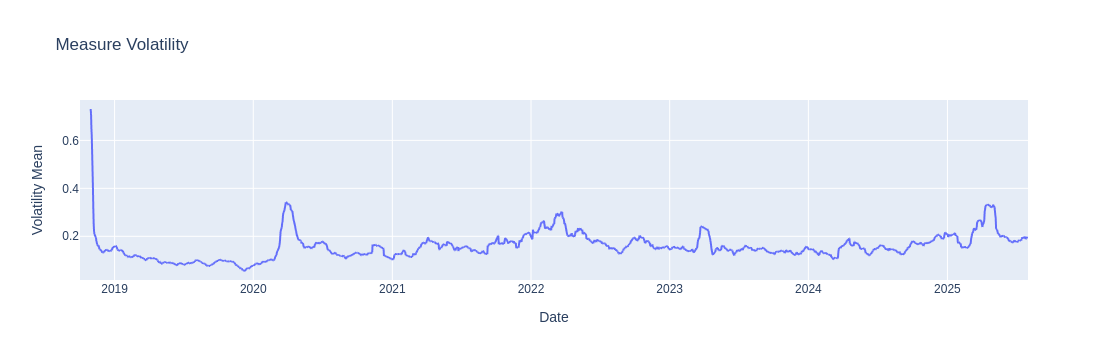

In [7]:
# Show it
fig = px.line(df_stock, x="date", y="volatility_mean", title="Measure Volatility", 
              labels={"date": "Date", "volatility_mean": "Volatility Mean"})
fig.show()

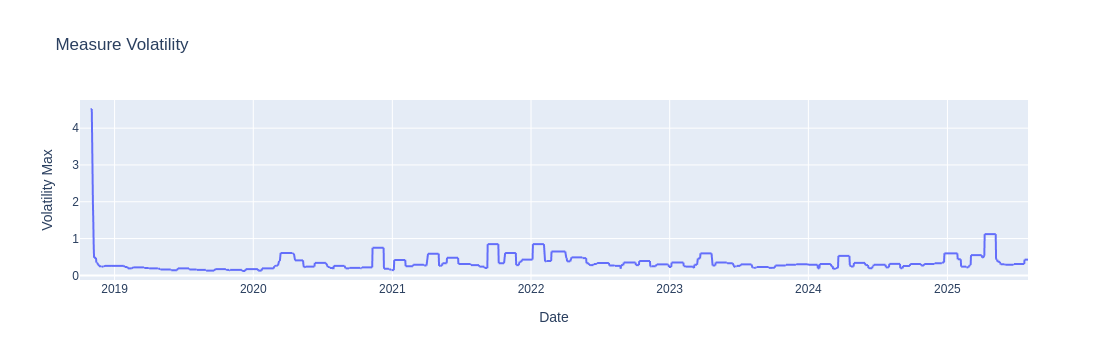

In [8]:
# Show it
fig = px.line(df_stock, x="date", y="volatility_max", title="Measure Volatility", 
              labels={"date": "Date", "volatility_max": "Volatility Max"})
fig.show()

### Truncate the timeframe

In [9]:
affected_rows = 0

# Update the database or not
truncate_date = input("Truncate Date (yyyy-mm-dd): ")
delete_string = f"DELETE FROM stock_price WHERE symbol='{symbol}' AND `date`<'{truncate_date}';"
truncate_bool = input("Truncate the database? (y/n): ")

if truncate_bool in ("y", "Y"):
    affected_rows = loader.query(delete_string)
    sleep(1)
    df_stock = pd.read_sql(select_query.format(symbol), create_engine(mariadb_string))
    df_stock["date"] = pd.to_datetime(df_stock["date"])

elif truncate_bool in ("n", "N"):
    df_stock = df_stock.loc[df_stock['date'] >= truncate_date]
    
print(df_stock.head())
print(df_stock.tail())
print(df_stock.info())
print("Affected Rows in database:", affected_rows)


Truncate Date (yyyy-mm-dd):  2019-01-01
Truncate the database? (y/n):  y


  symbol       date  open  high   low  close
0  NRDBY 2019-01-02  8.32  8.48  8.32  8.455
1  NRDBY 2019-01-03  8.44  8.51  8.41  8.490
2  NRDBY 2019-01-04  8.69  8.91  8.68  8.900
3  NRDBY 2019-01-07  8.82  8.93  8.81  8.930
4  NRDBY 2019-01-08  8.97  8.98  8.88  8.950
     symbol       date   open   high    low   close
1650  NRDBY 2025-07-28  14.81  14.81  14.61  14.610
1651  NRDBY 2025-07-29  14.80  14.91  14.65  14.785
1652  NRDBY 2025-07-30  14.84  14.89  14.70  14.750
1653  NRDBY 2025-07-31  14.61  14.74  14.61  14.700
1654  NRDBY 2025-08-01  14.64  14.73  14.53  14.680
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1655 entries, 0 to 1654
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   symbol  1655 non-null   object        
 1   date    1655 non-null   datetime64[ns]
 2   open    1655 non-null   float64       
 3   high    1655 non-null   float64       
 4   low     1655 non-null   float64       
 5  